# **딥러닝 모델 훈련 및 추론**

## **1. 드라이브 연결**

In [9]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2. 파라미터 설정, 데이터 로드, 데이터셋 분리**

- 데이터 전처리: MinMax Scaler
- 데이터 증강: Sliding Window

In [10]:
# ==========================================
# 1. 라이브러리 임포트 및 설정
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, f1_score
import os
import math

# CPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. 데이터 로드
# ==========================================
# 업로드된 파일명 사용 (환경에 맞게 경로 수정 가능)
file_path = "/content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx"

if os.path.exists(file_path):
    print(f"Loading data from: {file_path}")
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)
else:
    print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    # 임시 빈 데이터프레임 생성 (에러 방지용)
    df = pd.DataFrame()

# 센서 컬럼 정의
sensor_cols = [
    'BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A',
    'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err',
    'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err',
    'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve'
]

# ==========================================
# 3. 데이터 전처리 함수
# ==========================================
"""
    Wafer_ID 별로 그룹화하여 슬라이딩 윈도우를 적용하는 함수

    Args:
        df_target: 대상 데이터프레임
        wafer_col: Wafer ID 컬럼명
        sensor_cols: 센서 데이터 컬럼 리스트
        seq_len: 윈도우 크기
        scaler: 사용할 스케일러 (None이면 새로 생성)
        is_train: 학습 모드 여부 (True면 fit_transform, False면 transform)

    Returns:
        X_all: (N, seq_len, n_features) 형태의 numpy 배열
        scaler: 학습/사용된 스케일러
"""
def create_sequences_per_wafer(df_target, wafer_col, sensor_cols, seq_len, scaler=None, is_train=True):

    # 1. 스케일링 처리
    # (Wafer별로 따로 스케일링하면 Wafer 간의 상대적 크기 정보가 사라질 수 있으므로 전체 기준으로 합니다.)
    data_values = df_target[sensor_cols].values

    if is_train:
        # 학습용: Scaler 생성 및 학습
        if scaler is None:
            scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data_values)
    else:
        # 테스트용: 기존 Scaler 사용
        if scaler is None:
            raise ValueError("Test mode requires a fitted scaler.")
        data_scaled = scaler.transform(data_values)

    # 스케일링 된 데이터를 다시 DataFrame에 맵핑 (Wafer ID로 그룹핑하기 위해)
    df_scaled = pd.DataFrame(data_scaled, columns=sensor_cols, index=df_target.index)
    df_scaled[wafer_col] = df_target[wafer_col].values

    all_sequences = []

    # 2. Wafer ID 별로 슬라이딩 윈도우 적용
    unique_wafers = df_scaled[wafer_col].unique()

    for wafer in unique_wafers:
        # 특정 Wafer 데이터 추출
        wafer_data = df_scaled[df_scaled[wafer_col] == wafer][sensor_cols].values

        # 데이터가 윈도우 크기보다 작으면 스킵
        if len(wafer_data) < seq_len:
            continue

        # 슬라이딩 윈도우 생성
        for i in range(len(wafer_data) - seq_len + 1):
            all_sequences.append(wafer_data[i : i + seq_len])

    if len(all_sequences) == 0:
        return np.array([]), scaler

    return np.array(all_sequences), scaler

# ==========================================
# 4. 데이터셋 구성 (실험별 루프)
# ==========================================
experiments = ['l29', 'l31', 'l33']
datasets = {}

print("\n--- Preprocessing Data (Per Wafer Logic) ---")

for exp_id in experiments:
    print(f"\nProcessing Experiment: {exp_id}")

    # 1. 해당 실험 데이터 추출
    exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]

    if exp_df.empty:
        print(f"No data for {exp_id}")
        continue

    # 2. Wafer ID 추출 및 분할 (Label 기준)
    # 정상 Wafer와 불량 Wafer의 ID 리스트를 확보
    normal_wafer_ids = exp_df[exp_df['Label'] == 'Normal']['Wafer_ID'].unique()
    fault_wafer_ids = exp_df[exp_df['Label'] == 'Fault']['Wafer_ID'].unique()

    print(f"  - Total Normal Wafers: {len(normal_wafer_ids)}")
    print(f"  - Total Fault Wafers: {len(fault_wafer_ids)}")

    # 정상 Wafer가 너무 적으면 스킵
    if len(normal_wafer_ids) < 4:
        print("  - Not enough normal wafers to split.")
        continue

    # 3. Train / Test Split (Wafer ID 기준)
    # 정상 Wafer 중 80%는 학습용, 20%는 테스트용
    n_train_wafers = int(len(normal_wafer_ids) * 0.8)

    train_wafer_ids = normal_wafer_ids[:n_train_wafers]
    test_norm_wafer_ids = normal_wafer_ids[n_train_wafers:]

    # ID를 기준으로 데이터프레임 필터링
    train_df = exp_df[exp_df['Wafer_ID'].isin(train_wafer_ids)]
    test_norm_df = exp_df[exp_df['Wafer_ID'].isin(test_norm_wafer_ids)]
    test_fault_df = exp_df[exp_df['Wafer_ID'].isin(fault_wafer_ids)]

    # 4. 슬라이딩 윈도우 파라미터 설정
    SEQ_LEN = 10

    # (1) Train Data: Fit & Transform
    # 여기서 만들어진 scaler를 반환받아 테스트셋에 적용합니다.
    X_train, scaler = create_sequences_per_wafer(
        train_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=None, is_train=True
    )

    # (2) Test Normal Data: Transform Only
    X_test_normal, _ = create_sequences_per_wafer(
        test_norm_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=scaler, is_train=False     # 학습 데이터로 변환한 Scaler 적용
    )

    # (3) Test Fault Data: Transform Only
    if not test_fault_df.empty:
        X_test_fault, _ = create_sequences_per_wafer(
            test_fault_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=scaler, is_train=False    # 학습 데이터로 변환한 Scaler 적용
        )
    else:
        X_test_fault = np.array([])

    # 5. 결과 저장
    datasets[exp_id] = {
        'X_train': X_train,
        'X_test_norm': X_test_normal,
        'X_test_fault': X_test_fault,
        'scaler': scaler
    }

    print(f"  -> [{exp_id}] Result Shapes:")
    print(f"     X_train     : {X_train.shape}")
    print(f"     X_test_norm : {X_test_normal.shape}")
    print(f"     X_test_fault: {X_test_fault.shape}")

print("\nData preprocessing completed.")

Loading data from: /content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx

--- Preprocessing Data (Per Wafer Logic) ---

Processing Experiment: l29
  - Total Normal Wafers: 34
  - Total Fault Wafers: 9
  -> [l29] Result Shapes:
     X_train     : (2546, 10, 19)
     X_test_norm : (634, 10, 19)
     X_test_fault: (832, 10, 19)

Processing Experiment: l31
  - Total Normal Wafers: 37
  - Total Fault Wafers: 6
  -> [l31] Result Shapes:
     X_train     : (2589, 10, 19)
     X_test_norm : (722, 10, 19)
     X_test_fault: (488, 10, 19)

Processing Experiment: l33
  - Total Normal Wafers: 37
  - Total Fault Wafers: 6
  -> [l33] Result Shapes:
     X_train     : (2607, 10, 19)
     X_test_norm : (706, 10, 19)
     X_test_fault: (550, 10, 19)

Data preprocessing completed.


## **3. 함수 설정**

In [11]:
# ==========================================
# 1. 데이터 로드 함수 (수정됨)
# ==========================================
def get_data_loaders(exp_id, datasets, batch_size=32):
    print(f"\n📊 [Data Setup] Experiment: {exp_id}")

    # 이미 전처리 단계에서 Wafer_ID 별로 완벽하게 분할된 데이터를 가져옵니다.
    data = datasets[exp_id]
    X_train = data['X_train']
    X_test_norm = data['X_test_norm']
    X_test_fault = data['X_test_fault']

    print(f"   - Train (Normal): {X_train.shape}")
    print(f"   - Test Normal   : {X_test_norm.shape}")
    print(f"   - Test Fault    : {X_test_fault.shape}")

    # 1. Tensor 변환
    train_tensor = torch.FloatTensor(X_train).to(device)
    test_norm_tensor = torch.FloatTensor(X_test_norm).to(device)

    # Fault 데이터가 없는 경우(혹시 모를 예외) 처리
    if len(X_test_fault) > 0:
        test_fault_tensor = torch.FloatTensor(X_test_fault).to(device)
    else:
        test_fault_tensor = torch.FloatTensor([]).to(device)

    # 2. DataLoader 생성 (Train만 셔플)
    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)

    return train_loader, test_norm_tensor, test_fault_tensor

# ==========================================
# 2. 결과 시각화 함수 (기존 유지)
# ==========================================
def visualize_results(model_name, exp_id, scores, labels, threshold):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"[{exp_id}] {model_name} Performance Analysis", fontsize=16, fontweight='bold')

    # --- Plot 1: Confusion Matrix ---
    preds = (scores > threshold).astype(int)
    cm = confusion_matrix(labels, preds)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'], annot_kws={"size": 14})
    axes[0].set_title("Confusion Matrix", fontsize=14)
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # --- Plot 2: Anomaly Scores ---
    axes[1].plot(scores, label='Score', color='black', alpha=0.7, linewidth=1)
    axes[1].axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.4f})')

    # 불량 구간 시각화
    fault_indices = np.where(labels == 1)[0]
    if len(fault_indices) > 0:
        start_idx = fault_indices[0]
        end_idx = fault_indices[-1]
        axes[1].axvspan(start_idx, end_idx, color='red', alpha=0.2, label='Actual Fault')

    axes[1].set_title("Anomaly Scores", fontsize=14)
    axes[1].set_xlabel("Sample Index")
    axes[1].set_ylabel("Reconstruction Error")
    axes[1].legend(loc='upper left')

    # --- Plot 3: ROC Curve ---
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.05])
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_title("ROC Curve", fontsize=14)
    axes[2].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==========================================
# 3. 공통 평가 함수 (기존 유지)
# ==========================================
def evaluate_performance(model_name, exp_id, scores, labels):
    # Best F1 Score를 기준으로 Threshold 자동 계산
    precision, recall, thresholds = precision_recall_curve(labels, scores)

    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * recall * precision / (recall + precision)
    f1_scores = np.nan_to_num(f1_scores) # NaN 처리

    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_thresh = thresholds[best_idx]

    # AUC 계산
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    print(f"\n📌 [{model_name} - {exp_id}] Result Summary")
    print(f"   - AUROC         : {roc_auc:.4f}")
    print(f"   - Best F1-Score : {best_f1:.4f}")
    print(f"   - Best Threshold: {best_thresh:.6f}")

    visualize_results(model_name, exp_id, scores, labels, best_thresh)
    return roc_auc, best_f1


# **모델 구현 및 추론**

## **1. 1D-CNN**


==================== Processing 1D-CNN AE for l29 ====================

📊 [Data Setup] Experiment: l29
   - Train (Normal): (2546, 10, 19)
   - Test Normal   : (634, 10, 19)
   - Test Fault    : (832, 10, 19)
   -> Detected Window Size: 10, Features: 19
   - Training Start...
     Epoch [10/50] Loss: 0.077041
     Epoch [20/50] Loss: 0.074573
     Epoch [30/50] Loss: 0.073427
     Epoch [40/50] Loss: 0.072602
     Epoch [50/50] Loss: 0.071778
   - Training Complete.

📌 [1D-CNN AE - l29] Result Summary
   - AUROC         : 0.8361
   - Best F1-Score : 0.7863
   - Best Threshold: 0.204606


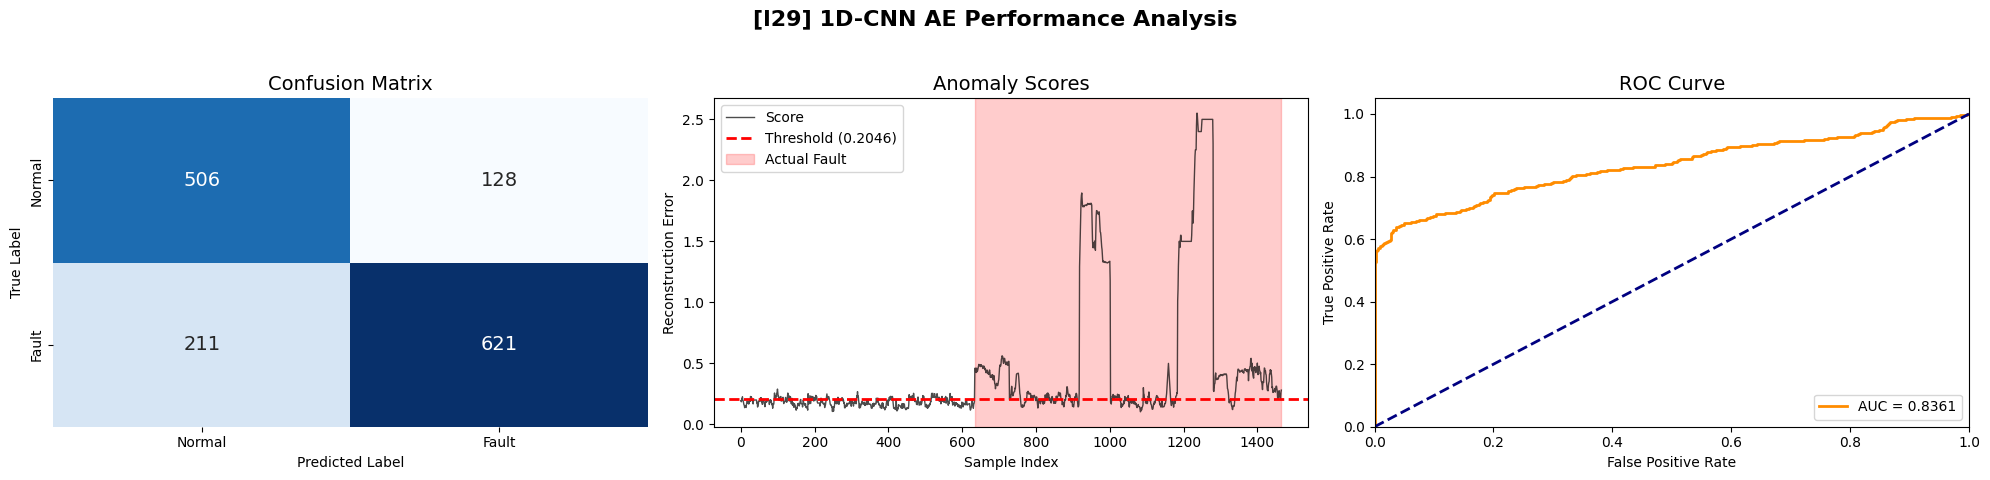


==================== Processing 1D-CNN AE for l31 ====================

📊 [Data Setup] Experiment: l31
   - Train (Normal): (2589, 10, 19)
   - Test Normal   : (722, 10, 19)
   - Test Fault    : (488, 10, 19)
   -> Detected Window Size: 10, Features: 19
   - Training Start...
     Epoch [10/50] Loss: 0.083315
     Epoch [20/50] Loss: 0.078058
     Epoch [30/50] Loss: 0.076492
     Epoch [40/50] Loss: 0.075254
     Epoch [50/50] Loss: 0.073879
   - Training Complete.

📌 [1D-CNN AE - l31] Result Summary
   - AUROC         : 0.7491
   - Best F1-Score : 0.6908
   - Best Threshold: 0.283556


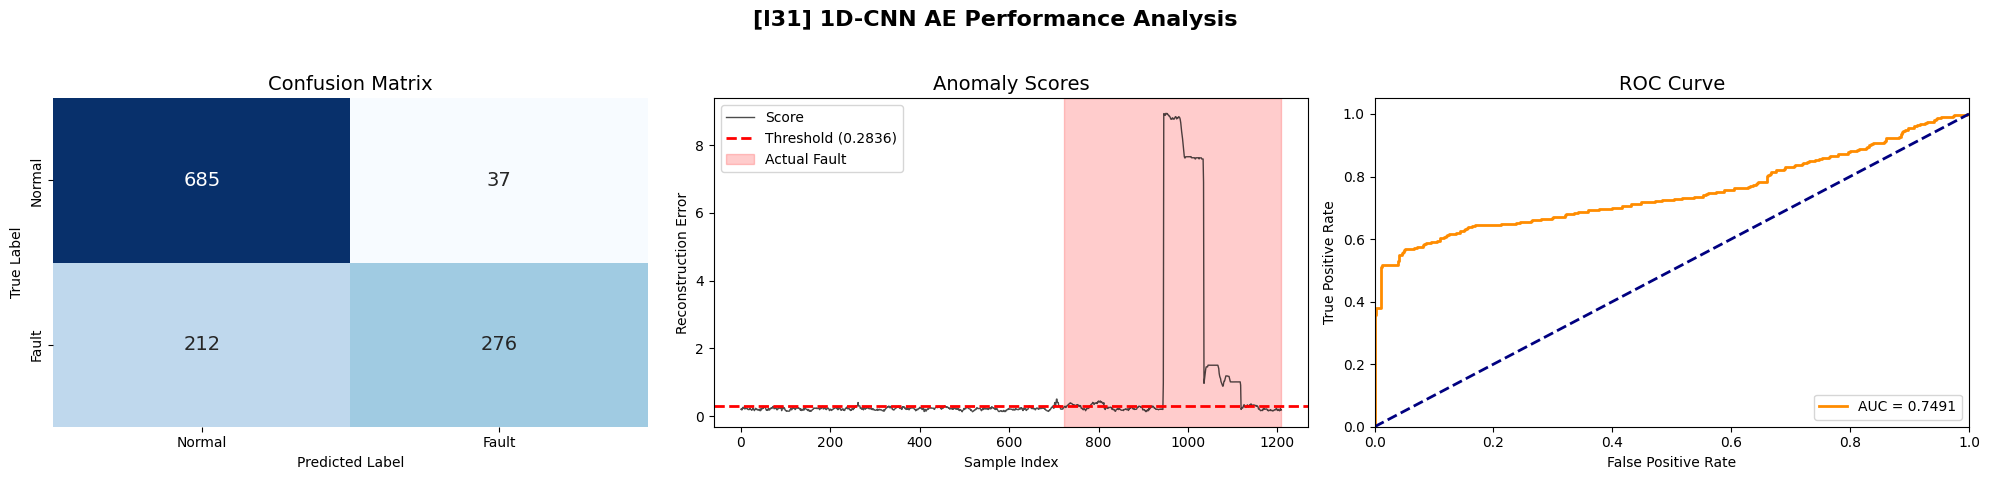


==================== Processing 1D-CNN AE for l33 ====================

📊 [Data Setup] Experiment: l33
   - Train (Normal): (2607, 10, 19)
   - Test Normal   : (706, 10, 19)
   - Test Fault    : (550, 10, 19)
   -> Detected Window Size: 10, Features: 19
   - Training Start...
     Epoch [10/50] Loss: 0.080359
     Epoch [20/50] Loss: 0.076998
     Epoch [30/50] Loss: 0.074858
     Epoch [40/50] Loss: 0.073768
     Epoch [50/50] Loss: 0.072664
   - Training Complete.

📌 [1D-CNN AE - l33] Result Summary
   - AUROC         : 0.6296
   - Best F1-Score : 0.6420
   - Best Threshold: 0.186424


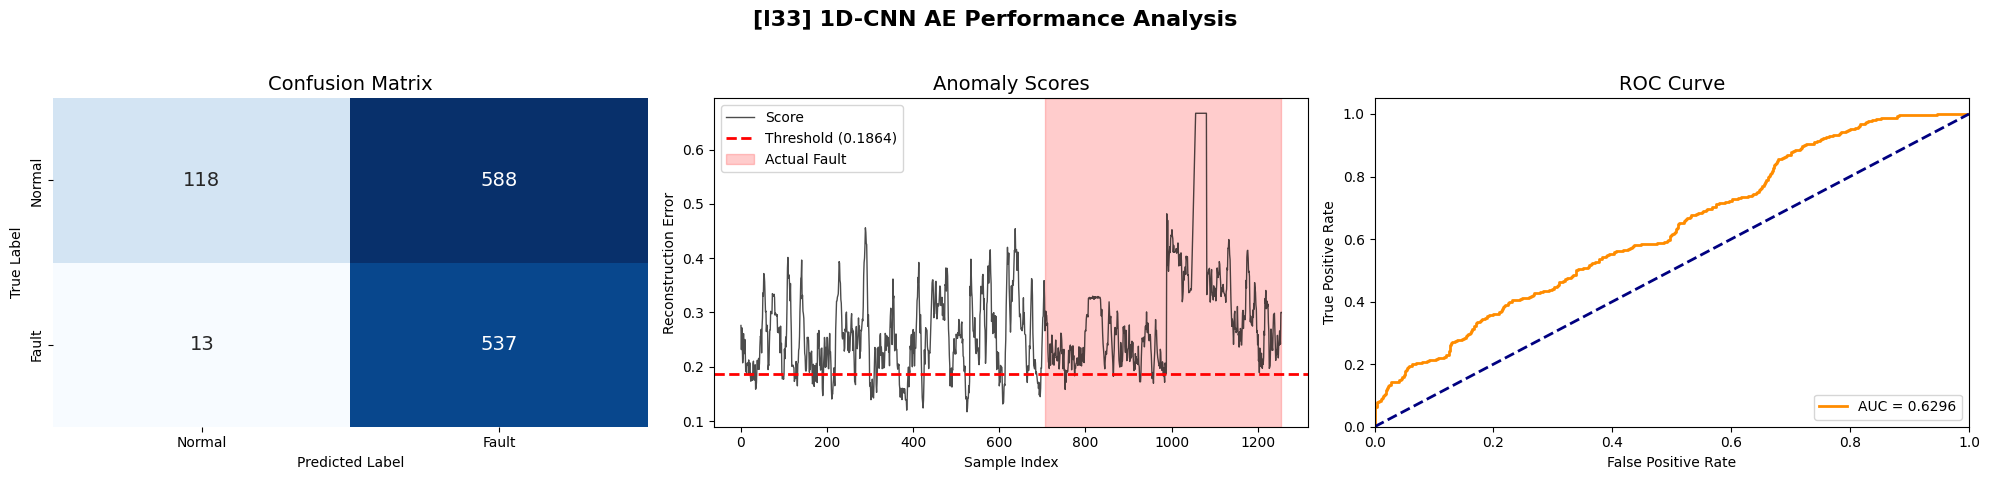

In [19]:
# ==========================================
# [Model 1] 1D-CNN AE Definition
# ==========================================
class Conv1DAE(nn.Module):
    def __init__(self, n_features=19, seq_len=10):
        super(Conv1DAE, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features

        # Encoder: (Batch, 19, 10) -> (Batch, 32, 10) -> (Batch, 16, 10)
        # 커널 사이즈를 3, Padding 1로 설정하여 시퀀스 길이(10)를 유지하며 특징 압축
        self.encoder = nn.Sequential(
            nn.Conv1d(n_features, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # Decoder: (Batch, 16, 10) -> (Batch, 32, 10) -> (Batch, 19, 10)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, n_features, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # 데이터가 0~1 사이이므로 Sigmoid 사용
        )

    def forward(self, x):
        # Input: (Batch, Seq_len, Features) -> (Batch, Features, Seq_len)
        x = x.transpose(1, 2)

        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        # Output: (Batch, Features, Seq_len) -> (Batch, Seq_len, Features)
        return decoded.transpose(1, 2)

# ==========================================
# Execution Loop: 1D-CNN AE
# ==========================================
# l29, l31, l33 실험 순차 진행
target_experiments = ['l29', 'l31', 'l33']

for exp in target_experiments:
    print(f"\n{'='*20} Processing 1D-CNN AE for {exp} {'='*20}")

    # 1. 데이터 로드
    train_loader, X_test_norm, X_test_fault = get_data_loaders(exp, datasets)

    # [핵심] 윈도우 크기 자동 감지
    sample_batch = next(iter(train_loader))[0]
    real_seq_len = sample_batch.shape[1]  # 예: 20
    n_features = sample_batch.shape[2]    # 예: 19

    print(f"   -> Detected Window Size: {real_seq_len}, Features: {n_features}")

    # 2. 모델 초기화 (감지된 값 적용)
    model = Conv1DAE(n_features=n_features, seq_len=real_seq_len).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.L1Loss()

    # 3. 학습 (Training)
    epochs = 50
    model.train()
    print("   - Training Start...")
    for epoch in range(epochs):
        loss_sum = 0
        for batch in train_loader:
            x = batch[0]
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, x)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        # 10 Epoch 마다 로그 출력
        if (epoch+1) % 10 == 0:
            print(f"     Epoch [{epoch+1}/{epochs}] Loss: {loss_sum / len(train_loader):.6f}")

    print("   - Training Complete.")

    # 4. 추론 (Inference)
    model.eval()
    with torch.no_grad():
        # 정상 데이터 복원 오차
        recon_norm = model(X_test_norm)
        diff_norm = torch.abs(X_test_norm - recon_norm)
        # (Batch, Seq, Feat) -> 각 샘플별, 센서별 평균 오차 -> 그 중 가장 큰 센서의 오차 선택 (LRE 방식)
        score_norm = torch.max(diff_norm.mean(dim=1), dim=1)[0].cpu().numpy()

        # 불량 데이터 복원 오차
        if len(X_test_fault) > 0:
            recon_fault = model(X_test_fault)
            diff_fault = torch.abs(X_test_fault - recon_fault)
            score_fault = torch.max(diff_fault.mean(dim=1), dim=1)[0].cpu().numpy()
        else:
            score_fault = np.array([])

    # 5. 성능 평가 및 시각화
    # 정상 + 불량 합치기
    scores = np.concatenate([score_norm, score_fault])
    labels = np.concatenate([np.zeros(len(score_norm)), np.ones(len(score_fault))])

    evaluate_performance("1D-CNN AE", exp, scores, labels)

## **2. LSTM-AE**


==================== Processing LSTM-AE for l29 ====================

📊 [Data Setup] Experiment: l29
   - Train (Normal): (2546, 10, 19)
   - Test Normal   : (634, 10, 19)
   - Test Fault    : (832, 10, 19)
   -> Detected Window Size: 10
   -> Detected Features: 19
   - Training Start...
     Epoch [10/50] Loss: 0.030046
     Epoch [20/50] Loss: 0.014202
     Epoch [30/50] Loss: 0.013183
     Epoch [40/50] Loss: 0.012816
     Epoch [50/50] Loss: 0.012651
   - Training Complete.

📌 [LSTM-AE - l29] Result Summary
   - AUROC         : 0.8685
   - Best F1-Score : 0.8097
   - Best Threshold: 0.013024


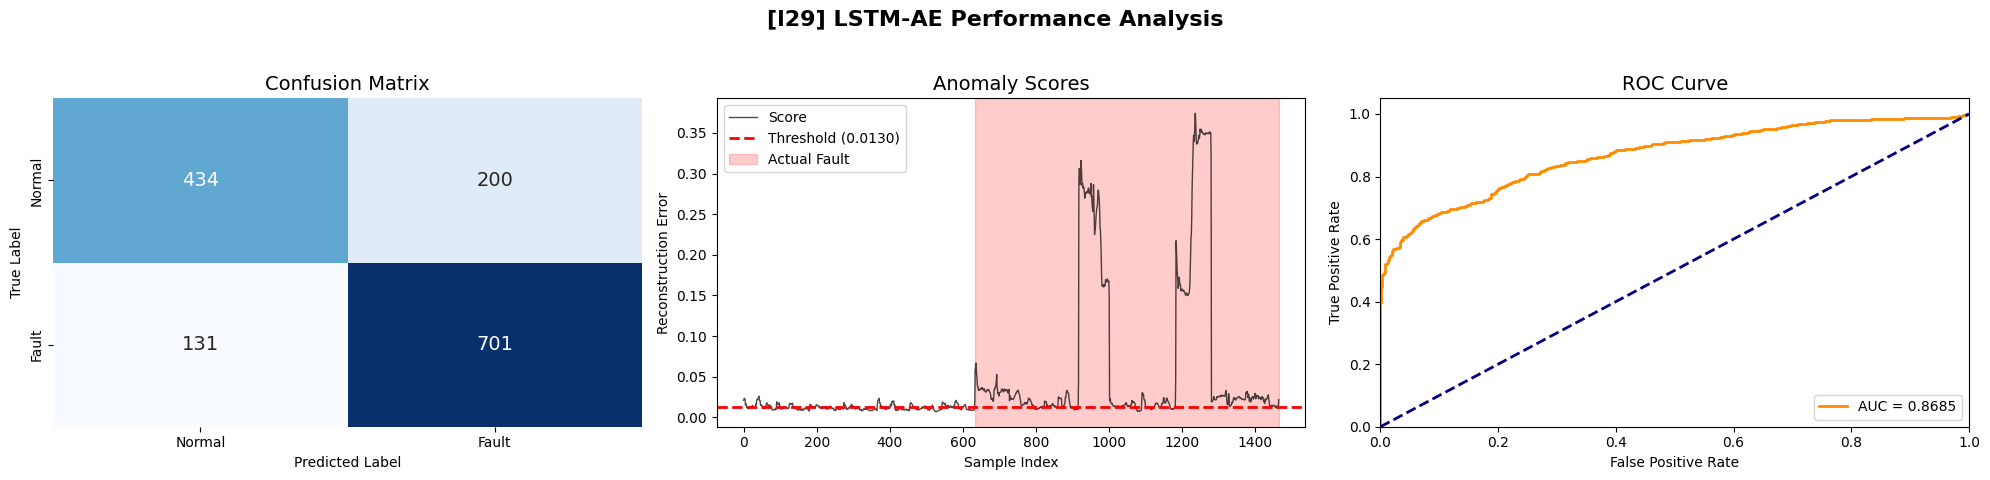


==================== Processing LSTM-AE for l31 ====================

📊 [Data Setup] Experiment: l31
   - Train (Normal): (2589, 10, 19)
   - Test Normal   : (722, 10, 19)
   - Test Fault    : (488, 10, 19)
   -> Detected Window Size: 10
   -> Detected Features: 19
   - Training Start...
     Epoch [10/50] Loss: 0.034884
     Epoch [20/50] Loss: 0.015786
     Epoch [30/50] Loss: 0.014677
     Epoch [40/50] Loss: 0.013992
     Epoch [50/50] Loss: 0.013498
   - Training Complete.

📌 [LSTM-AE - l31] Result Summary
   - AUROC         : 0.8125
   - Best F1-Score : 0.7145
   - Best Threshold: 0.016188


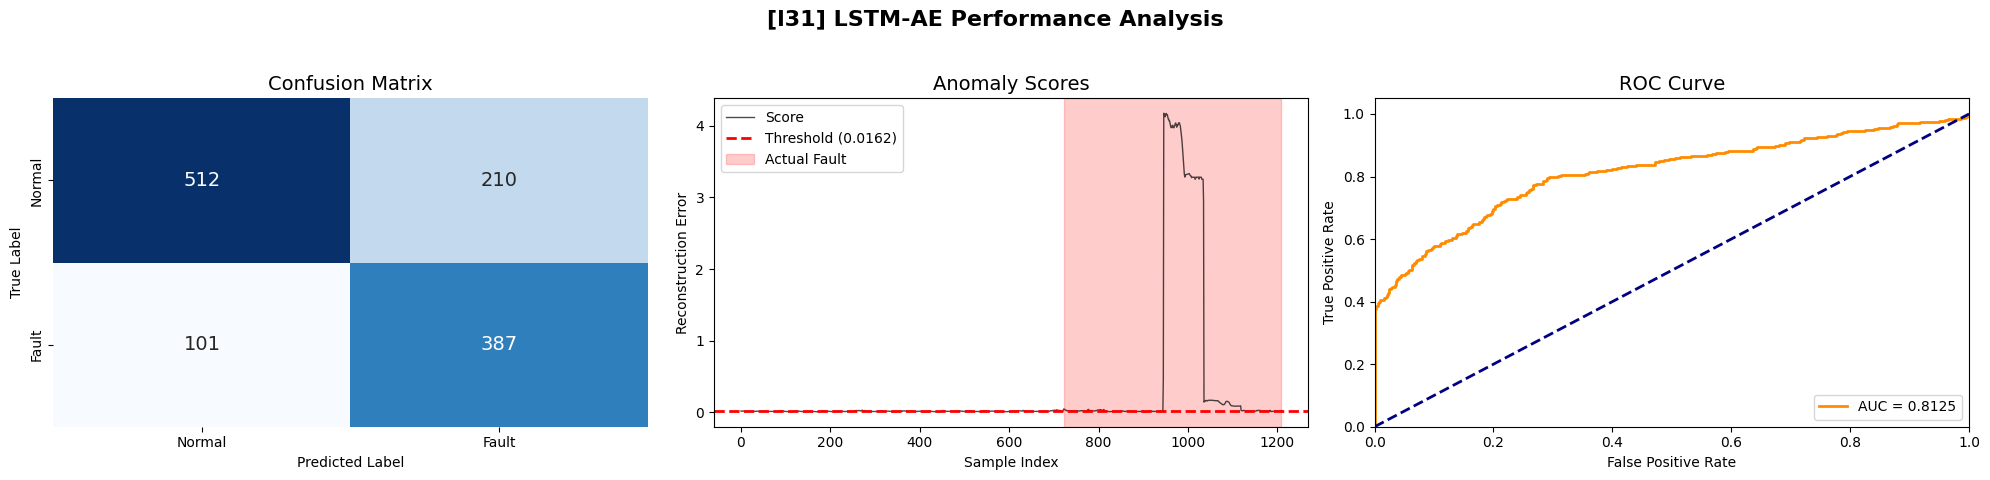


==================== Processing LSTM-AE for l33 ====================

📊 [Data Setup] Experiment: l33
   - Train (Normal): (2607, 10, 19)
   - Test Normal   : (706, 10, 19)
   - Test Fault    : (550, 10, 19)
   -> Detected Window Size: 10
   -> Detected Features: 19
   - Training Start...
     Epoch [10/50] Loss: 0.029200
     Epoch [20/50] Loss: 0.014926
     Epoch [30/50] Loss: 0.014014
     Epoch [40/50] Loss: 0.013424
     Epoch [50/50] Loss: 0.013118
   - Training Complete.

📌 [LSTM-AE - l33] Result Summary
   - AUROC         : 0.8278
   - Best F1-Score : 0.7285
   - Best Threshold: 0.015931


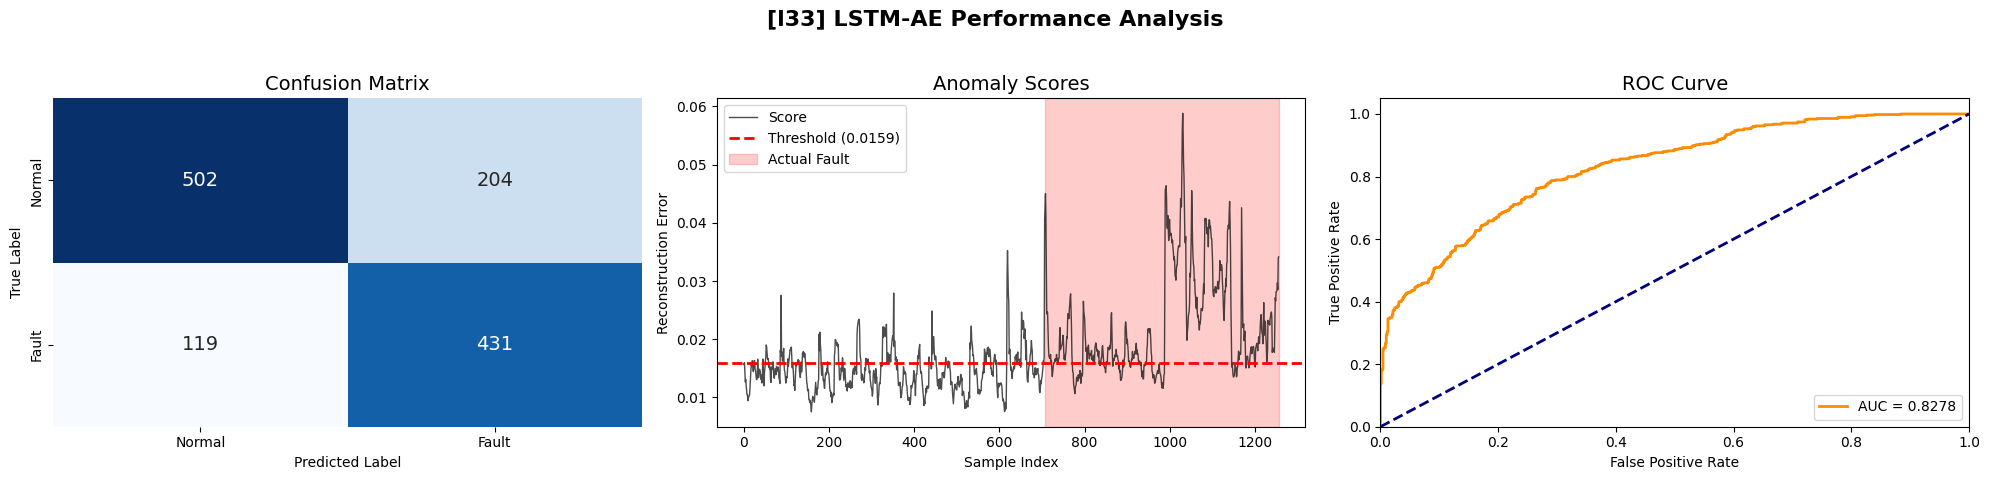

In [13]:
# ==========================================
# [Model 2] LSTM-AE Definition (Modified)
# ==========================================
class LSTMAE(nn.Module):
    def __init__(self, n_features=19, seq_len=10):
        super(LSTMAE, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features

        # Encoder: 19 -> 64 -> 32 -> 16
        self.enc1 = nn.LSTM(n_features, 64, batch_first=True)
        self.enc2 = nn.LSTM(64, 32, batch_first=True)
        self.enc3 = nn.LSTM(32, 16, batch_first=True)

        # Decoder: 16 -> 32 -> 64 -> 19
        # Latent Vector(16)를 seq_len(10)만큼 반복해서 입력으로 받음
        self.dec1 = nn.LSTM(16, 32, batch_first=True)
        self.dec2 = nn.LSTM(32, 64, batch_first=True)
        self.output = nn.Linear(64, n_features)

    def forward(self, x):
        # x: (Batch, Seq_len, Features)

        # Encoding
        x, _ = self.enc1(x)
        x, _ = self.enc2(x)
        _, (hidden, _) = self.enc3(x)
        # hidden shape: (1, Batch, 16) -> (Layers, Batch, Hidden)

        # Latent Vector Repeat
        # (1, Batch, 16) -> (Batch, 1, 16) -> (Batch, Seq_len, 16)
        x = hidden.permute(1, 0, 2).repeat(1, self.seq_len, 1)

        # Decoding
        x, _ = self.dec1(x)
        x, _ = self.dec2(x)

        # (Batch, Seq_len, 64) -> (Batch, Seq_len, 19)
        x = self.output(x)
        return x

# ==========================================
# Execution Loop: LSTM-AE
# ==========================================
# l29, l31, l33 실험 순차 진행
for exp in experiments:
    print(f"\n{'='*20} Processing LSTM-AE for {exp} {'='*20}")

    # 1. 데이터 로드
    train_loader, X_test_norm, X_test_fault = get_data_loaders(exp, datasets)

    # [핵심 수정] 데이터에서 실제 윈도우 크기(seq_len) 자동 추출
    # train_loader의 첫 번째 배치를 꺼내서 크기 확인
    sample_batch = next(iter(train_loader))[0] # (Batch, Seq_Len, Features)
    real_seq_len = sample_batch.shape[1]       # 예: 20
    n_features = sample_batch.shape[2]         # 예: 19

    print(f"   -> Detected Window Size: {real_seq_len}")
    print(f"   -> Detected Features: {n_features}")

    # 2. 모델 초기화 (감지된 seq_len 사용)
    model = LSTMAE(n_features=n_features, seq_len=real_seq_len).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # 3. 학습 (Training)
    epochs = 50 # CNN과 동일하게 50으로 설정 (데이터가 작아 학습이 빠름)
    print("   - Training Start...")

    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for batch in train_loader:
            x = batch[0]
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, x)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        if (epoch+1) % 10 == 0:
            print(f"     Epoch [{epoch+1}/{epochs}] Loss: {loss_sum / len(train_loader):.6f}")

    print("   - Training Complete.")

    # 4. 추론 (Inference)
    model.eval()
    with torch.no_grad():
        # 정상 데이터 Score (MSE 방식)
        recon_norm = model(X_test_norm)
        # (Batch, Seq, Feat) -> Sample별 MSE 계산 (dim=1,2 평균)
        score_norm = torch.mean((X_test_norm - recon_norm)**2, dim=(1,2)).cpu().numpy()

        # 불량 데이터 Score
        if len(X_test_fault) > 0:
            recon_fault = model(X_test_fault)
            score_fault = torch.mean((X_test_fault - recon_fault)**2, dim=(1,2)).cpu().numpy()
        else:
            score_fault = np.array([])

    # 5. 성능 평가
    scores = np.concatenate([score_norm, score_fault])
    labels = np.concatenate([np.zeros(len(score_norm)), np.ones(len(score_fault))])

    evaluate_performance("LSTM-AE", exp, scores, labels)

## **3. USAD**


==================== Processing USAD for l29 ====================

📊 [Data Setup] Experiment: l29
   - Train (Normal): (2546, 10, 19)
   - Test Normal   : (634, 10, 19)
   - Test Fault    : (832, 10, 19)
   -> Detected Window Size: 10
   -> Flatten Input Dim: 190
   - Training Start...
Epoch [10/100] (Weights -> Recon: 0.1000, Adv: 0.9000) Loss1: 8.245442, Loss2: -7.174032
Epoch [20/100] (Weights -> Recon: 0.0500, Adv: 0.9500) Loss1: 8.604050, Loss2: -8.070743
Epoch [30/100] (Weights -> Recon: 0.0333, Adv: 0.9667) Loss1: 8.723581, Loss2: -8.369398
Epoch [40/100] (Weights -> Recon: 0.0250, Adv: 0.9750) Loss1: 8.783825, Loss2: -8.518910
Epoch [50/100] (Weights -> Recon: 0.0200, Adv: 0.9800) Loss1: 8.820456, Loss2: -8.608921
Epoch [60/100] (Weights -> Recon: 0.0167, Adv: 0.9833) Loss1: 8.844780, Loss2: -8.668768
Epoch [70/100] (Weights -> Recon: 0.0143, Adv: 0.9857) Loss1: 8.861139, Loss2: -8.710471
Epoch [80/100] (Weights -> Recon: 0.0125, Adv: 0.9875) Loss1: 8.875097, Loss2: -8.743392


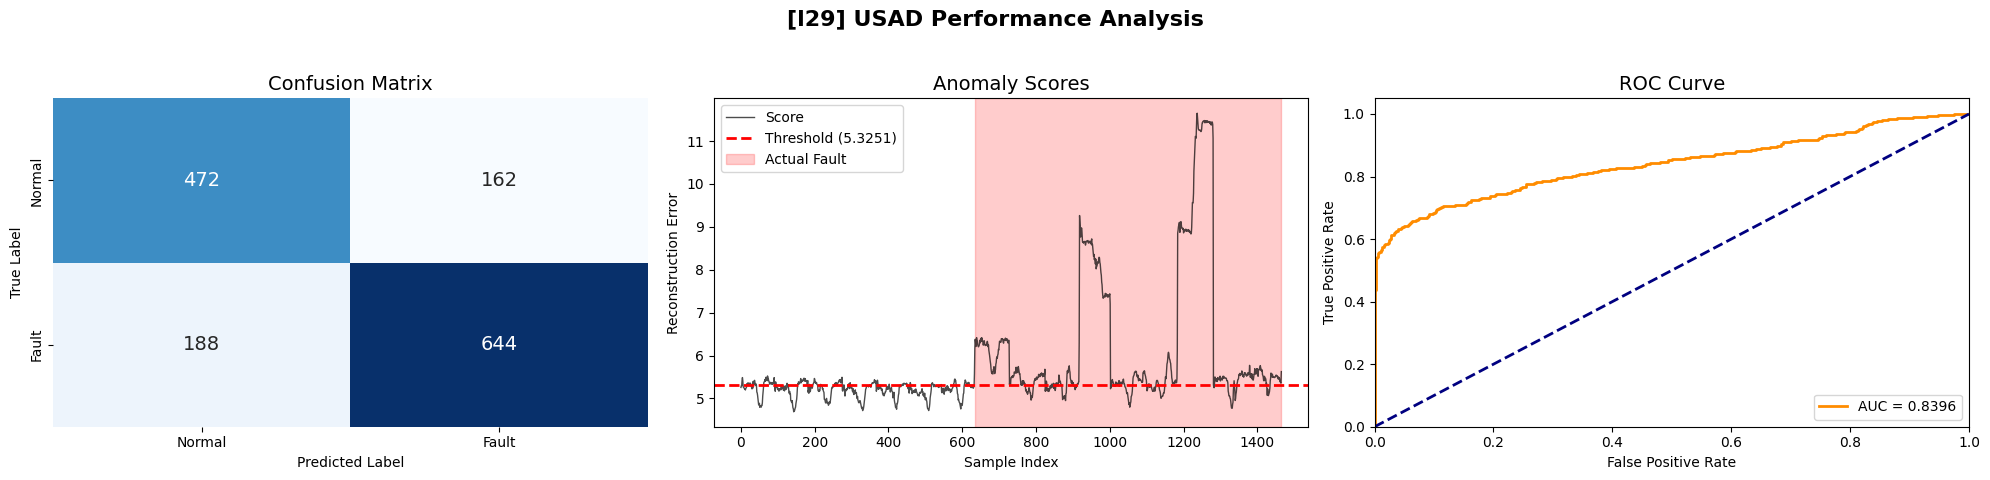


==================== Processing USAD for l31 ====================

📊 [Data Setup] Experiment: l31
   - Train (Normal): (2589, 10, 19)
   - Test Normal   : (722, 10, 19)
   - Test Fault    : (488, 10, 19)
   -> Detected Window Size: 10
   -> Flatten Input Dim: 190
   - Training Start...
Epoch [10/100] (Weights -> Recon: 0.1000, Adv: 0.9000) Loss1: 8.078922, Loss2: -7.003365
Epoch [20/100] (Weights -> Recon: 0.0500, Adv: 0.9500) Loss1: 8.409231, Loss2: -7.878905
Epoch [30/100] (Weights -> Recon: 0.0333, Adv: 0.9667) Loss1: 8.523339, Loss2: -8.170943
Epoch [40/100] (Weights -> Recon: 0.0250, Adv: 0.9750) Loss1: 8.580684, Loss2: -8.316659
Epoch [50/100] (Weights -> Recon: 0.0200, Adv: 0.9800) Loss1: 8.615315, Loss2: -8.404377
Epoch [60/100] (Weights -> Recon: 0.0167, Adv: 0.9833) Loss1: 8.637852, Loss2: -8.462641
Epoch [70/100] (Weights -> Recon: 0.0143, Adv: 0.9857) Loss1: 8.653888, Loss2: -8.504318
Epoch [80/100] (Weights -> Recon: 0.0125, Adv: 0.9875) Loss1: 8.666382, Loss2: -8.535772


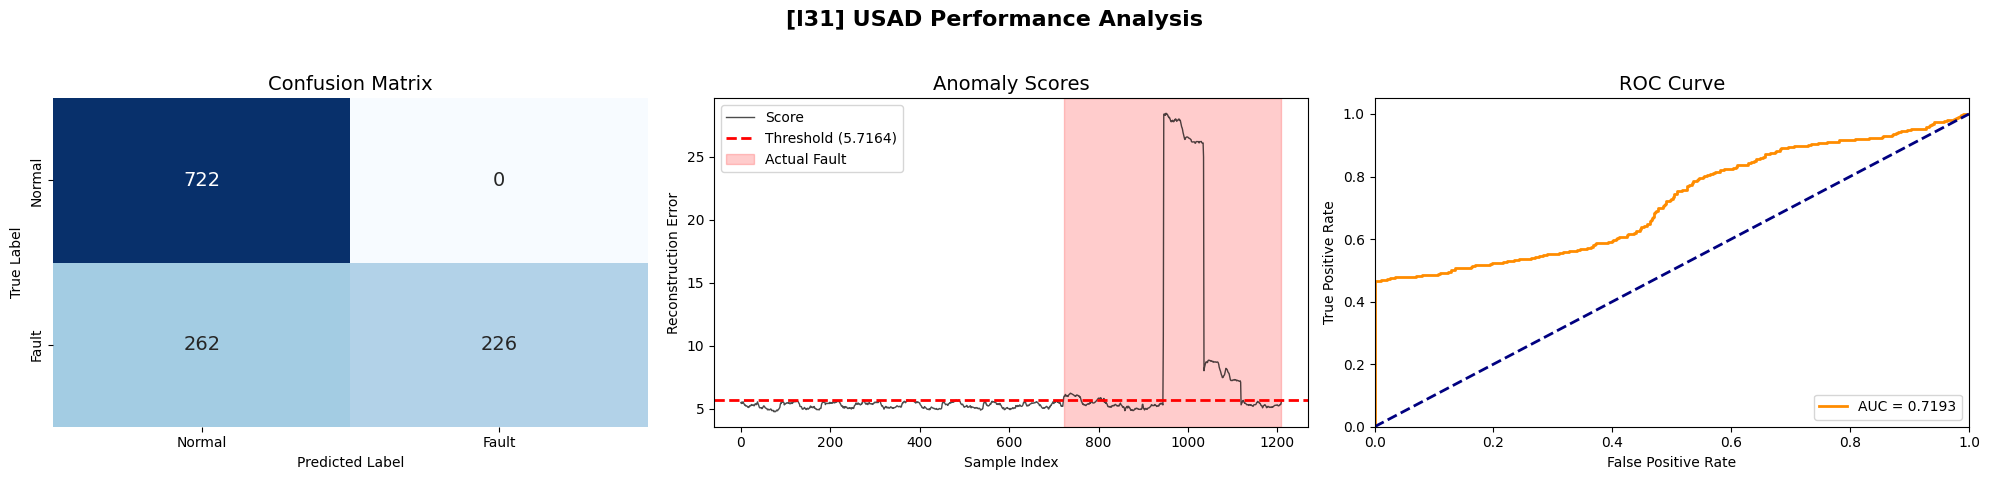


==================== Processing USAD for l33 ====================

📊 [Data Setup] Experiment: l33
   - Train (Normal): (2607, 10, 19)
   - Test Normal   : (706, 10, 19)
   - Test Fault    : (550, 10, 19)
   -> Detected Window Size: 10
   -> Flatten Input Dim: 190
   - Training Start...
Epoch [10/100] (Weights -> Recon: 0.1000, Adv: 0.9000) Loss1: 7.549130, Loss2: -6.547654
Epoch [20/100] (Weights -> Recon: 0.0500, Adv: 0.9500) Loss1: 7.864409, Loss2: -7.365277
Epoch [30/100] (Weights -> Recon: 0.0333, Adv: 0.9667) Loss1: 7.971907, Loss2: -7.639612
Epoch [40/100] (Weights -> Recon: 0.0250, Adv: 0.9750) Loss1: 8.022850, Loss2: -7.774131
Epoch [50/100] (Weights -> Recon: 0.0200, Adv: 0.9800) Loss1: 8.055519, Loss2: -7.856899
Epoch [60/100] (Weights -> Recon: 0.0167, Adv: 0.9833) Loss1: 8.075402, Loss2: -7.910336
Epoch [70/100] (Weights -> Recon: 0.0143, Adv: 0.9857) Loss1: 8.092507, Loss2: -7.951421
Epoch [80/100] (Weights -> Recon: 0.0125, Adv: 0.9875) Loss1: 8.103352, Loss2: -7.980243


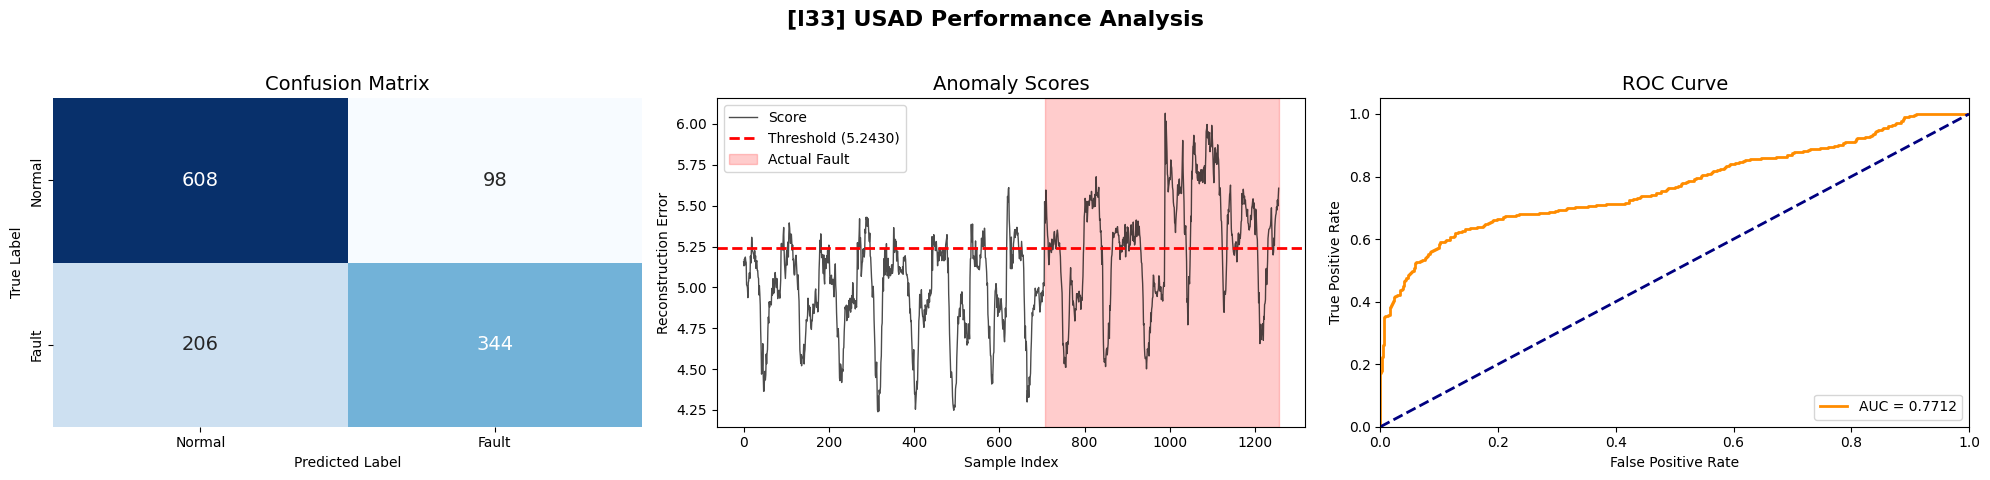

In [14]:
# ==========================================
# [Model 3] USAD Definition (Modified)
# ==========================================
class USAD(nn.Module):
    def __init__(self, w_size, z_size):
        super(USAD, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(w_size, w_size // 2),
            nn.ReLU(True),
            nn.Linear(w_size // 2, w_size // 4),
            nn.ReLU(True),
            nn.Linear(w_size // 4, z_size),
            nn.ReLU(True)
        )
        # Decoder 1
        self.decoder1 = nn.Sequential(
            nn.Linear(z_size, w_size // 4),
            nn.ReLU(True),
            nn.Linear(w_size // 4, w_size // 2),
            nn.ReLU(True),
            nn.Linear(w_size // 2, w_size),
            nn.Sigmoid() # Data range 0~1
        )
        # Decoder 2
        self.decoder2 = nn.Sequential(
            nn.Linear(z_size, w_size // 4),
            nn.ReLU(True),
            nn.Linear(w_size // 4, w_size // 2),
            nn.ReLU(True),
            nn.Linear(w_size // 2, w_size),
            nn.Sigmoid() # Data range 0~1
        )

    def forward(self, x):
        # 1. Encode Input
        z = self.encoder(x)

        # 2. Reconstruct with AE1
        w1 = self.decoder1(z)

        # 3. Reconstruct with AE2
        w2 = self.decoder2(z)

        # 4. Adversarial Path (Encode w1 -> Decode with AE2)
        w3 = self.decoder2(self.encoder(w1))

        return w1, w2, w3

# ==========================================
# USAD Training Function
# ==========================================

def train_usad(model, train_loader, optimizer1, optimizer2, n_epochs):
    model.train()

    for epoch in range(n_epochs):
        loss1_list = []
        loss2_list = []

        # [논문 수식 반영 1] 가중치 스케줄링 (Eq. 7, 8)
        n = epoch + 1
        w_recon = 1.0 / n
        w_adv = 1.0 - (1.0 / n)

        for batch in train_loader:
            x = batch[0].to(device)
            x = x.view(x.size(0), -1) # Flatten

            # ==========================================
            # Phase 1: Train AE1 (Eq. 7)
            # ==========================================
            # 모델 전체 Forward
            w1, w2, w3 = model(x)

            # [논문 수식 반영 2] L2 Norm (Eq. 2)
            l2_w1 = torch.norm(x - w1, p=2, dim=1)
            l2_w3 = torch.norm(x - w3, p=2, dim=1)

            # Loss1 = (1/n)*Recon(AE1) + (1 - 1/n)*Recon(AE2(AE1(x)))
            loss1 = w_recon * torch.mean(l2_w1) + w_adv * torch.mean(l2_w3)

            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()
            loss1_list.append(loss1.item())

            # ==========================================
            # Phase 2: Train AE2 (Eq. 8)
            # ==========================================
            # [핵심 수정] Phase 2를 위한 수동 Forward 및 Detach 적용

            # 1. AE1의 출력(가짜 데이터) 생성
            # 여기서 AE1의 출력인 w1_gen에 .detach()를 붙여야
            # AE2 학습 시 공유 Encoder가 망가지는 것을 방지함
            z = model.encoder(x)
            w1_gen = model.decoder1(z)
            w1_detached = w1_gen.detach()  # <--- [중요] 그래디언트 차단

            # 2. AE2가 가짜 데이터를 입력받아 재구성 (Adversarial Path)
            # w3 = AE2(AE1(x))
            w3 = model.decoder2(model.encoder(w1_detached))

            # 3. AE2가 진짜 데이터를 입력받아 재구성 (Reconstruction Path)
            w2 = model.decoder2(z) # z는 위에서 구한 것 재사용 (x -> encoder -> z)

            # L2 Norm 계산
            l2_w2 = torch.norm(x - w2, p=2, dim=1)
            l2_w3 = torch.norm(x - w3, p=2, dim=1)

            # Loss2 = (1/n)*Recon(AE2) - (1 - 1/n)*Recon(AE2(AE1(x)))
            # 적대적 손실(w3) 앞의 마이너스(-) 부호는 오차를 최대화하라는 의미
            loss2 = w_recon * torch.mean(l2_w2) - w_adv * torch.mean(l2_w3)

            optimizer2.zero_grad()
            loss2.backward()
            optimizer2.step()
            loss2_list.append(loss2.item())

        # Log
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}] "
                  f"(Weights -> Recon: {w_recon:.4f}, Adv: {w_adv:.4f}) "
                  f"Loss1: {np.mean(loss1_list):.6f}, Loss2: {np.mean(loss2_list):.6f}")

    return np.mean(loss1_list) + np.mean(loss2_list)


# ==========================================
# USAD Score Calculation Function
# ==========================================
def get_usad_score(inputs, model, alpha=0.5, beta=0.5):
    model.eval()
    with torch.no_grad():
        inputs = inputs.to(device)
        inputs = inputs.view(inputs.size(0), -1)

        w1, w2, w3 = model(inputs)

        # 논문 수식 (9)에 따라 L2 Norm 사용
        diff1 = torch.norm(inputs - w1, p=2, dim=1)  # ||W - AE1(W)||
        diff2 = torch.norm(inputs - w3, p=2, dim=1)  # ||W - AE2(AE1(W))||

        score = alpha * diff1 + beta * diff2

    return score.cpu().numpy()

# ==========================================
# Execution Loop: USAD
# ==========================================
# Parameters
seq_len = 10
n_features = 19
input_dim = seq_len * n_features # 10 * 19 = 190 (Flatten Dimension)
latent_dim = 40 # Latent Space Dimension
n_epochs = 100

for exp_id in experiments:
    print(f"\n{'='*20} Processing USAD for {exp_id} {'='*20}")

    # 1. 데이터 로드
    train_loader, X_test_norm, X_test_fault = get_data_loaders(exp_id, datasets)

    # [핵심] 윈도우 크기 및 입력 차원 자동 계산
    sample_batch = next(iter(train_loader))[0]
    real_seq_len = sample_batch.shape[1] # 20
    n_features = sample_batch.shape[2]   # 19

    # Flatten Dimension 계산 (20 * 19 = 380)
    input_dim = real_seq_len * n_features

    print(f"   -> Detected Window Size: {real_seq_len}")
    print(f"   -> Flatten Input Dim: {input_dim}")

    # 2. 모델 초기화 (계산된 input_dim 사용)
    usad_model = USAD(w_size=input_dim, z_size=40).to(device)

    opt1 = optim.Adam(list(usad_model.encoder.parameters()) + list(usad_model.decoder1.parameters()), lr=1e-3)
    opt2 = optim.Adam(list(usad_model.encoder.parameters()) + list(usad_model.decoder2.parameters()), lr=1e-3)

    # 3. Training
    print("   - Training Start...")
    train_usad(usad_model, train_loader, opt1, opt2, n_epochs)
    print("   - Training Complete.")

    # 4. Inference & Scoring
    # alpha=0.5, beta=0.5 gives equal weight to reconstruction and adversarial error
    score_norm = get_usad_score(X_test_norm, usad_model, alpha=0.5, beta=0.5)

    if len(X_test_fault) > 0:
        score_fault = get_usad_score(X_test_fault, usad_model, alpha=0.5, beta=0.5)
    else:
        score_fault = np.array([])

    # 5. Evaluation
    scores = np.concatenate([score_norm, score_fault])
    labels = np.concatenate([np.zeros(len(score_norm)), np.ones(len(score_fault))])

    evaluate_performance("USAD", exp_id, scores, labels)

## **4. Anomaly Transformer**


==================== Run Anomaly Transformer: l29 ====================

📊 [Data Setup] Experiment: l29
   - Train (Normal): (2546, 10, 19)
   - Test Normal   : (634, 10, 19)
   - Test Fault    : (832, 10, 19)
 -> Detected: Window=10, Features=19
 -> Training Started...
    Epoch [10/100] Recon Loss: 0.001205
    Epoch [20/100] Recon Loss: 0.027230
    Epoch [30/100] Recon Loss: 0.027455
    Epoch [40/100] Recon Loss: 0.026814
    Epoch [50/100] Recon Loss: 0.028876
    Epoch [60/100] Recon Loss: 0.027678
    Epoch [70/100] Recon Loss: 0.029041
    Epoch [80/100] Recon Loss: 0.030134
    Epoch [90/100] Recon Loss: 0.029632
    Epoch [100/100] Recon Loss: 0.029986
 -> Evaluating...

📌 [Anomaly Transformer - l29] Result Summary
   - AUROC         : 0.7756
   - Best F1-Score : 0.7510
   - Best Threshold: 0.002695


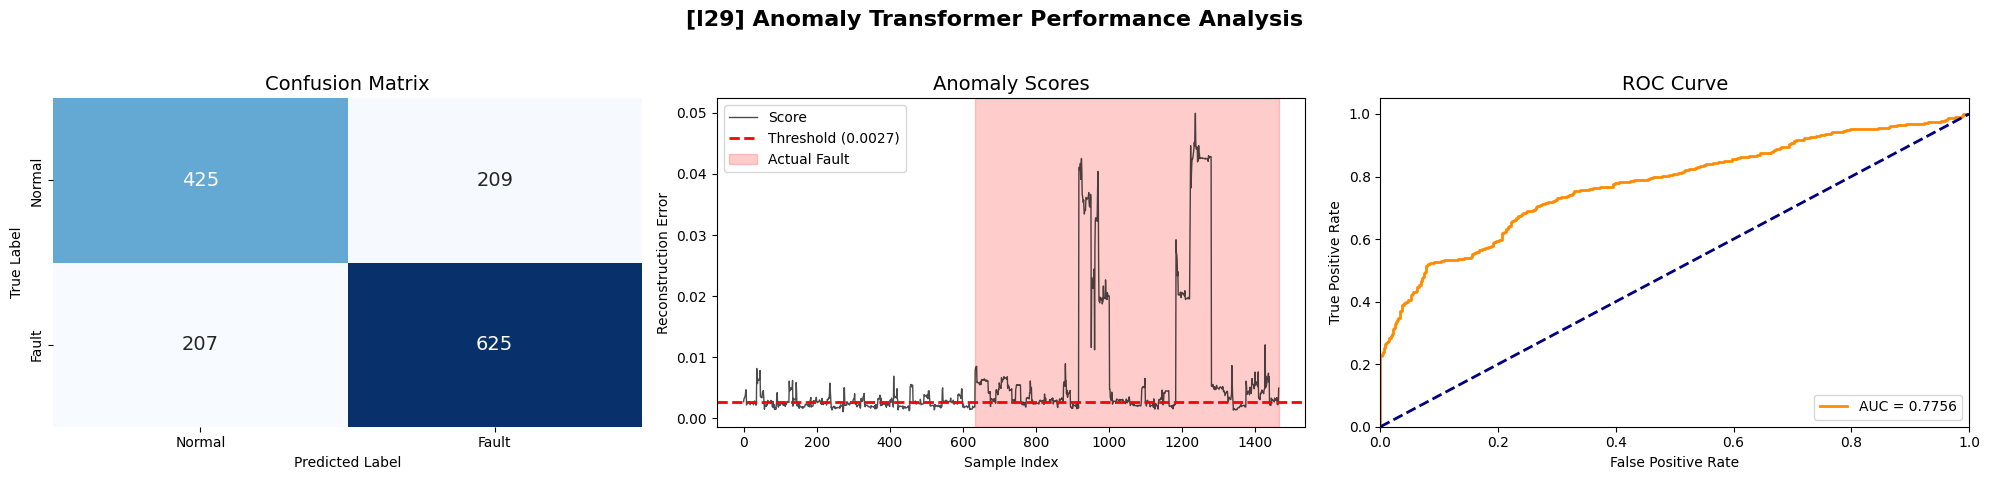


==================== Run Anomaly Transformer: l31 ====================

📊 [Data Setup] Experiment: l31
   - Train (Normal): (2589, 10, 19)
   - Test Normal   : (722, 10, 19)
   - Test Fault    : (488, 10, 19)
 -> Detected: Window=10, Features=19
 -> Training Started...
    Epoch [10/100] Recon Loss: 0.001178
    Epoch [20/100] Recon Loss: 0.027796
    Epoch [30/100] Recon Loss: 0.025351
    Epoch [40/100] Recon Loss: 0.024005
    Epoch [50/100] Recon Loss: 0.021958
    Epoch [60/100] Recon Loss: 0.024593
    Epoch [70/100] Recon Loss: 0.021898
    Epoch [80/100] Recon Loss: 0.022815
    Epoch [90/100] Recon Loss: 0.022568
    Epoch [100/100] Recon Loss: 0.021016
 -> Evaluating...

📌 [Anomaly Transformer - l31] Result Summary
   - AUROC         : 0.7569
   - Best F1-Score : 0.6528
   - Best Threshold: 0.001859


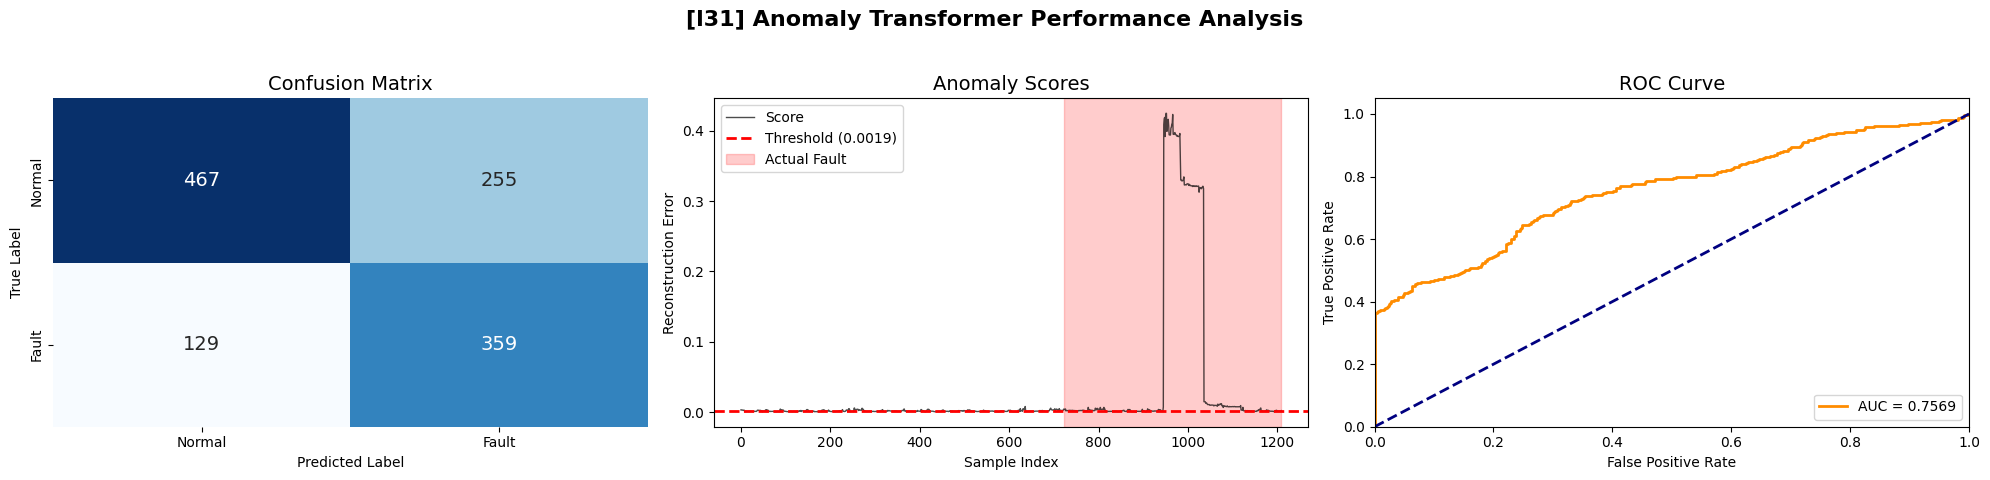


==================== Run Anomaly Transformer: l33 ====================

📊 [Data Setup] Experiment: l33
   - Train (Normal): (2607, 10, 19)
   - Test Normal   : (706, 10, 19)
   - Test Fault    : (550, 10, 19)
 -> Detected: Window=10, Features=19
 -> Training Started...
    Epoch [10/100] Recon Loss: 0.001181
    Epoch [20/100] Recon Loss: 0.025045
    Epoch [30/100] Recon Loss: 0.023879
    Epoch [40/100] Recon Loss: 0.020128
    Epoch [50/100] Recon Loss: 0.024284
    Epoch [60/100] Recon Loss: 0.018388
    Epoch [70/100] Recon Loss: 0.019507
    Epoch [80/100] Recon Loss: 0.018518
    Epoch [90/100] Recon Loss: 0.017530
    Epoch [100/100] Recon Loss: 0.018599
 -> Evaluating...

📌 [Anomaly Transformer - l33] Result Summary
   - AUROC         : 0.7860
   - Best F1-Score : 0.7340
   - Best Threshold: 0.001461


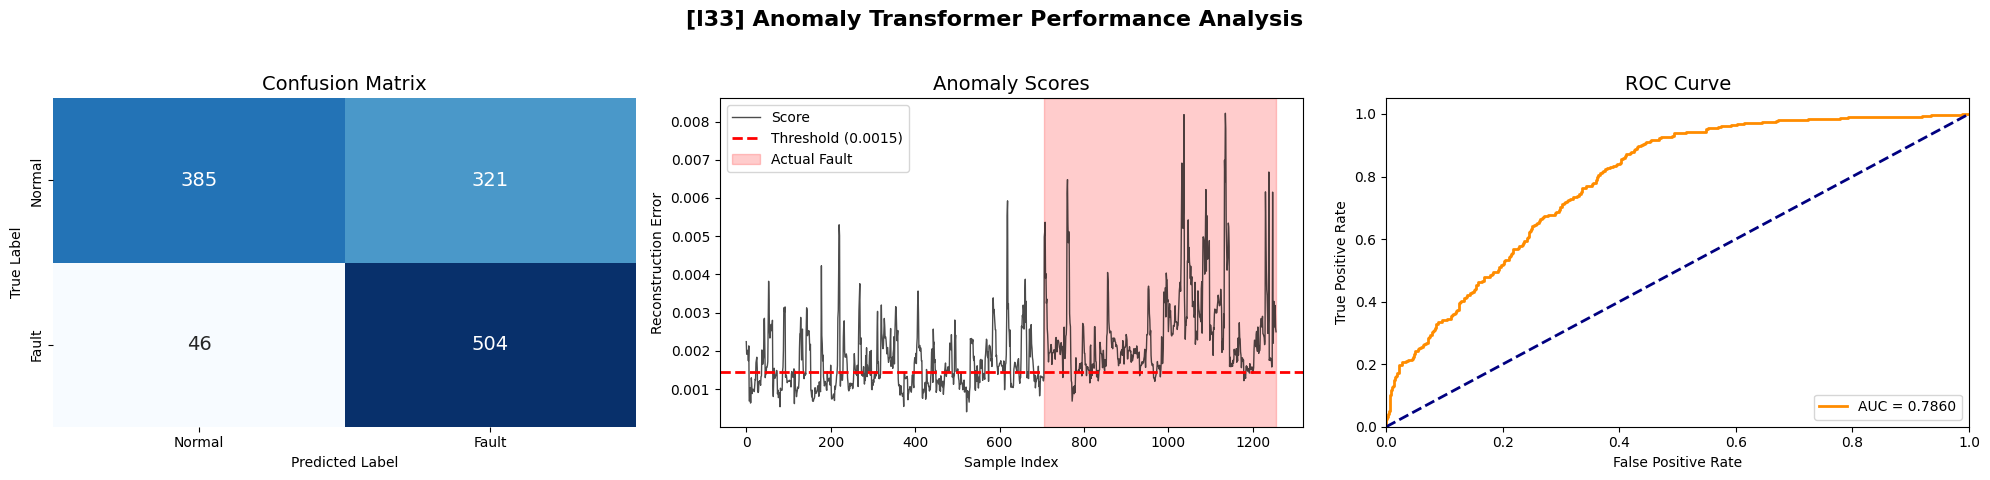

In [15]:
class AnomalyAttention(nn.Module):
    def __init__(self, d_model, n_heads, window_size):
        super(AnomalyAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        # Series Association (Q, K, V)
        self.qkv = nn.Linear(d_model, d_model * 3)

        # Prior Association (Sigma)
        self.sigma_proj = nn.Linear(d_model, n_heads)
        self.out_proj = nn.Linear(d_model, d_model)

        # Distance Matrix (Pre-computed)
        self.register_buffer('distances', torch.zeros(window_size, window_size))
        for i in range(window_size):
            for j in range(window_size):
                self.distances[i, j] = abs(i - j)

    def forward(self, x):
        B, L, D = x.shape

        # Q, K, V Splitting
        qkv = self.qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.view(B, L, self.n_heads, -1).permute(0, 2, 1, 3), qkv)

        # 1. Series Association (S)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        series_attn = torch.softmax(scores, dim=-1)

        # 2. Prior Association (P)
        # Sigma Calculation (Sigmoid for stability + scaling)
        sigma = self.sigma_proj(x).view(B, L, self.n_heads).permute(0, 2, 1).unsqueeze(-1)
        sigma = torch.sigmoid(sigma) * 3 + 0.1

        # Gaussian Kernel Calculation
        dist = self.distances.unsqueeze(0).unsqueeze(0).to(x.device)
        # 논문 수식 (2) 정규화 계수 포함
        gaussian_norm = 1.0 / (math.sqrt(2 * math.pi) * sigma)
        gaussian = gaussian_norm * torch.exp(- (dist ** 2) / (2 * (sigma ** 2)))

        # Rescale (Row sum = 1)
        prior_attn = gaussian / (gaussian.sum(dim=-1, keepdim=True) + 1e-8)

        # 3. Reconstruction
        out = torch.matmul(series_attn, v)
        out = out.permute(0, 2, 1, 3).reshape(B, L, D)

        return self.out_proj(out), series_attn, prior_attn

class AnomalyTransformerLayer(nn.Module):
    def __init__(self, d_model, n_heads, window_size, dropout=0.1):
        super().__init__()
        self.attn = AnomalyAttention(d_model, n_heads, window_size)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.ff = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4 * d_model, d_model)
        )

    def forward(self, x):
        new_x, s, p = self.attn(x)
        x = self.norm1(x + self.dropout(new_x))
        new_x = self.ff(x)
        x = self.norm2(x + self.dropout(new_x))
        return x, s, p

class AnomalyTransformer(nn.Module):
    def __init__(self, n_features, d_model=512, n_heads=8, layers=3, window_size=10):
        super(AnomalyTransformer, self).__init__()
        self.embed = nn.Linear(n_features, d_model)
        self.blocks = nn.ModuleList([
            AnomalyTransformerLayer(d_model, n_heads, window_size) for _ in range(layers)
        ])
        self.out = nn.Linear(d_model, n_features)

    def forward(self, x):
        x = self.embed(x)
        s_list, p_list = [], []
        for block in self.blocks:
            x, s, p = block(x)
            s_list.append(s)
            p_list.append(p)
        return self.out(x), s_list, p_list

# KL Divergence Utility
def kl_loss(p, q):
    res = p * (torch.log(p + 1e-8) - torch.log(q + 1e-8))
    return torch.mean(torch.sum(res, dim=-1))

# ==========================================
# 5. 학습 및 추론 루프 (사용자 코드 호환)
# ==========================================
# Hyperparameters (논문 설정)
EPOCHS = 100 # 테스트를 위해 조절 가능
LR = 1e-4
K_LAMBDA = 3.0 # Minimax Weight
D_MODEL = 512
N_HEADS = 8
N_LAYERS = 3

# 실험 루프
for exp_id in experiments:
    if exp_id not in datasets:
        continue

    print(f"\n{'='*20} Run Anomaly Transformer: {exp_id} {'='*20}")

    # 1. 데이터 로드 (사용자 정의 함수 사용)
    # get_data_loaders는 (train_loader, test_norm_tensor, test_fault_tensor)를 반환
    train_loader, test_norm_tensor, test_fault_tensor = get_data_loaders(exp_id, datasets, batch_size=32)

    # 2. 입력 차원 자동 감지
    sample_batch = next(iter(train_loader))[0]
    WINDOW_SIZE = sample_batch.shape[1]
    N_FEATURES = sample_batch.shape[2]
    print(f" -> Detected: Window={WINDOW_SIZE}, Features={N_FEATURES}")

    # 3. 모델 초기화
    model = AnomalyTransformer(
        n_features=N_FEATURES,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        layers=N_LAYERS,
        window_size=WINDOW_SIZE
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()

    # 4. 학습 (Minimax Strategy)
    print(" -> Training Started...")
    model.train()

    for epoch in range(EPOCHS):
        loss_list = []
        current_lambda = 0 if epoch < 10 else K_LAMBDA # Warm-up

        for batch in train_loader:
            x = batch[0].to(device)
            optimizer.zero_grad()

            rec, s_list, p_list = model(x)
            rec_loss = criterion(rec, x)

            prior_loss = 0
            series_loss = 0

            # Calculate KL Divergence for all layers
            for s, p in zip(s_list, p_list):
                # KL(P||S) + KL(S||P)
                prior_loss += kl_loss(p, s.detach()) + kl_loss(s.detach(), p)
                series_loss += kl_loss(p.detach(), s) + kl_loss(s, p.detach())

            prior_loss /= len(s_list)
            series_loss /= len(s_list)

            # --- Minimax Optimization ---
            # 1. Minimize Phase: Prior tries to approximate Series
            loss_minimize = rec_loss + current_lambda * prior_loss

            # 2. Maximize Phase: Series tries to maximize distance from Prior
            # (Reconstruction loss constraints Series to be valid)
            loss_maximize = rec_loss - current_lambda * series_loss

            # Combine & Backward
            total_loss = loss_minimize + loss_maximize
            total_loss.backward()
            optimizer.step()

            loss_list.append(rec_loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"    Epoch [{epoch+1}/{EPOCHS}] Recon Loss: {np.mean(loss_list):.6f}")

    # 5. 추론 및 평가
    print(" -> Evaluating...")
    model.eval()

    def get_anomaly_score(inputs):
        """
        Anomaly Score = Softmax(-AssociationDiscrepancy) * ReconstructionError
        """
        # Batch 단위 처리를 위해 DataLoader 사용 (메모리 보호)
        loader = DataLoader(TensorDataset(inputs), batch_size=32, shuffle=False)
        scores = []

        with torch.no_grad():
            for batch in loader:
                x_batch = batch[0].to(device)
                rec, s_list, p_list = model(x_batch)

                # 1. Reconstruction Error (Average over features) -> Shape: (B, L)
                rec_err = torch.mean((x_batch - rec) ** 2, dim=2)

                # 2. Association Discrepancy
                ass_dis = 0
                for s, p in zip(s_list, p_list):
                    # KL Divergence per timestep -> Shape: (B, H, L)
                    # Sum over last dim (distribution dim)
                    p_kl = torch.sum(p * (torch.log(p + 1e-8) - torch.log(s + 1e-8)), dim=-1)
                    s_kl = torch.sum(s * (torch.log(s + 1e-8) - torch.log(p + 1e-8)), dim=-1)
                    ass_dis += p_kl + s_kl

                # Average over layers & heads -> Shape: (B, L)
                ass_dis = torch.mean(ass_dis, dim=1) / len(s_list)

                # 3. Final Score Calculation
                # Softmax over temporal dimension
                temp = 0.5
                score_map = F.softmax(-ass_dis / temp, dim=1) * rec_err

                # Sample-level score (Mean or Max over window)
                scores.append(torch.mean(score_map, dim=1).cpu().numpy())

        return np.concatenate(scores)

    # 정상 데이터 평가
    score_norm = get_anomaly_score(test_norm_tensor)

    # 불량 데이터 평가
    if len(test_fault_tensor) > 0:
        score_fault = get_anomaly_score(test_fault_tensor)
    else:
        score_fault = np.array([])

    # 결과 통합
    scores = np.concatenate([score_norm, score_fault])
    labels = np.concatenate([np.zeros(len(score_norm)), np.ones(len(score_fault))])

    # 6. 성과 지표 출력
    evaluate_performance("Anomaly Transformer", exp_id, scores, labels)